In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/MyDrive")

Mounted at /content/gdrive


In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

IMAGE LOADING PATHS

In [ ]:
normal_lung_folder = "/content/gdrive/MyDrive/Dataset/Train/Lung_Normal"
cf_lung_folder = "/content/gdrive/MyDrive/Dataset/Train/Lung_Ancestry"

In [ ]:
normal_lung_paths = [os.path.join(normal_lung_folder, img) for img in os.listdir(normal_lung_folder)]
cf_lung_paths = [os.path.join(cf_lung_folder, img) for img in os.listdir(cf_lung_folder)]

In [ ]:
def preprocess_images(image_paths):
    preprocessed_images = []
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            #  LBP preprocessing
            lbp_radius = 1
            lbp_points = 8 * lbp_radius
            lbp = local_binary_pattern(image, lbp_points, lbp_radius, method='uniform')
            preprocessed_images.append(lbp)
        else:
            print("Failed to load image:", path)
    return preprocessed_images


In [ ]:
normal_lung_images = preprocess_images(normal_lung_paths)
cf_lung_images = preprocess_images(cf_lung_paths)

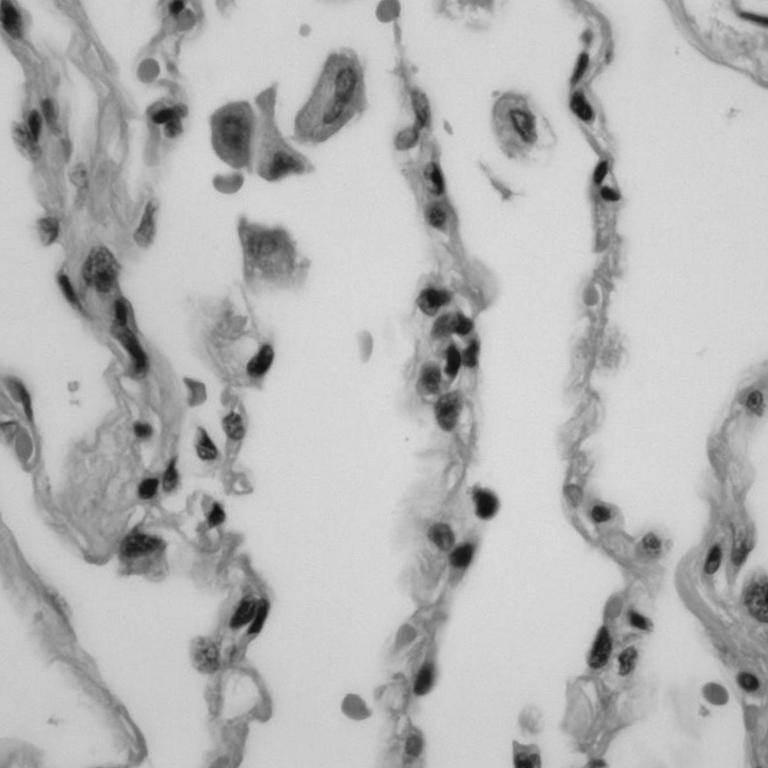

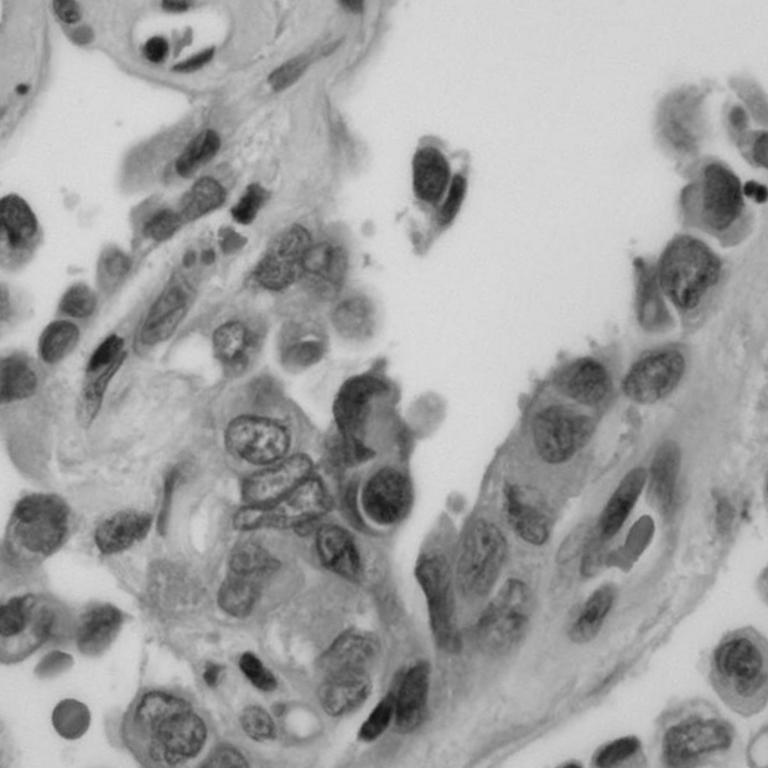

In [ ]:
from google.colab.patches import cv2_imshow
normal_lung_images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in normal_lung_paths]
cf_lung_images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in cf_lung_paths]

cv2_imshow(normal_lung_images[0])
cv2_imshow(cf_lung_images[0])

In [ ]:
from skimage.feature import greycomatrix, greycoprops

In [ ]:
def extract_features(images):
    features = []
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    for image in images:
        glcm = greycomatrix(image, distances, angles, levels=256, symmetric=True, normed=True)
        contrast = greycoprops(glcm, 'contrast').ravel()
        dissimilarity = greycoprops(glcm, 'dissimilarity').ravel()
        homogeneity = greycoprops(glcm, 'homogeneity').ravel()
        energy = greycoprops(glcm, 'energy').ravel()
        correlation = greycoprops(glcm, 'correlation').ravel()
        image_features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation])
        features.append(image_features)
    return np.array(features)


In [ ]:
normal_lung_features = extract_features(normal_lung_images)
cf_lung_features = extract_features(cf_lung_images)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

In [ ]:
X = np.concatenate((normal_lung_features, cf_lung_features), axis=0)
y = np.concatenate((np.zeros(len(normal_lung_features)), np.ones(len(cf_lung_features))), axis=0)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test))

Epoch 1/10
21/21 [==============================] - 1s 14ms/step - loss: 0.2876 - accuracy: 0.8824 - val_loss: 0.4799 - val_accuracy: 0.8036
Epoch 2/10
21/21 [==============================] - 0s 5ms/step - loss: 0.2714 - accuracy: 0.8854 - val_loss: 0.4723 - val_accuracy: 0.7500
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 0.2834 - accuracy: 0.8899 - val_loss: 0.4068 - val_accuracy: 0.8333
Epoch 4/10
21/21 [==============================] - 0s 5ms/step - loss: 0.3063 - accuracy: 0.8750 - val_loss: 0.5174 - val_accuracy: 0.7024
Epoch 5/10
21/21 [==============================] - 0s 4ms/step - loss: 0.2769 - accuracy: 0.8735 - val_loss: 0.6514 - val_accuracy: 0.6548
Epoch 6/10
21/21 [==============================] - 0s 4ms/step - loss: 0.2890 - accuracy: 0.8914 - val_loss: 0.3609 - val_accuracy: 0.8810
Epoch 7/10
21/21 [==============================] - 0s 5ms/step - loss: 0.2544 - accuracy: 0.8914 - val_loss: 0.2957 - val_accuracy: 0.9107
Epoch 8/10
21/21 [=

In [ ]:
test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print("Test accuracy:", test_acc)


6/6 [==============================] - 0s 3ms/step - loss: 0.2145 - accuracy: 0.9226
Test accuracy: 0.9226190447807312


In [ ]:
for i in range(len(X_test_cnn)):
    prediction = model.predict(X_test_cnn[i:i+1])[0][0]
    if prediction >= 0.5:
        result = "Cystic Fibrosis"
    else:
        result = "Normal"
    print("Prediction:", result)
    print("Accuracy:", test_acc)

    cv2_imshow(cv2.imread(cf_lung_paths[i]) if y_test[i] == 1 else cv2.imread(normal_lung_paths[i]))

Output hidden; open in https://colab.research.google.com to view.